In [2]:
from __future__ import print_function, division

import time
import datetime
from dateutil import parser

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import re
import string
import pprint
from textblob import TextBlob

import os
import subprocess

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

In [3]:
from pymongo import MongoClient
client = MongoClient(port=12345)# Tunnel to my mongoDB client
db = client.tech_news_data
arts = db.articles

In [4]:
arts.count()

1409

# Random pull

In [5]:
#pull a random document from database
import random
def get_random_doc():
    c = arts.find()
    count = c.count()
    return c[random.randrange(count)]

doc = get_random_doc()['title']

doc

'Thirty Meter Telescope nears a construction permit—with conditions'

# Extraction and processing

In [5]:
class Articles(object):
    """A memory-friendly way to load large corpora"""
    def __init__(self, connection):
        self.connection = connection

    def __iter__(self):
        # iterate through all file names in our directory
        for item in self.connection.find():
            yield item


In [6]:
def preprocess_series_text(data):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())
    data = data.map(alphanum_lambda)

    #some characters don't show up in standard punctuation
    punct = string.punctuation + '‘’“”£€–…'
    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(punct))
    punc_lambda = lambda x: punc_re.sub(' ', x)
    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda) 
    
    # stem words
    stemmer = SnowballStemmer('english')
    stemmer_fun = lambda x: list(map(stemmer.stem, x))
    data = data.map(stemmer_fun)
    
    return data

In [7]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent = SentimentIntensityAnalyzer()

In [8]:
#testing the sentiment analyzer
sent.polarity_scores('the quick brown fox jumps over the lazy dog')['compound']

-0.3612

In [29]:
#Load mongodb data into pandas and process

articles = Articles(arts)

art_df = pd.DataFrame.from_dict(list(articles))
art_df.drop('_id', axis=1, inplace=True)
art_df['tags'] = art_df['tags'].apply(lambda x: list(set([i.lower() for i in x])))

art_df['polarity'] = art_df['body'].apply(lambda x: sent.polarity_scores(x)['compound'])
art_df['polarity'].fillna(0)

#Wipe empty rows

#art_df['title2'] = preprocess_series_text(art_df['title'])
#mask = art_df['title2'].map(len) > 0
#art_df['title2'] = art_df['title2'].loc[mask].reset_index(drop=True)
#art_df['title2'] = art_df['title2'].apply(lambda x: ' '.join(x))

art_df['body'] = preprocess_series_text(art_df['body'])
mask = art_df['body'].map(len) > 0
art_df['body'] = art_df['body'].loc[mask].reset_index(drop=True)
art_df['body'] = art_df['body'].apply(lambda x: ' '.join(x))

In [55]:
date = datetime.datetime.today() -  datetime.timedelta(days=7)

art_df = art_df[art_df.date >= date]

In [56]:
art_df.shape

(494, 8)

In [57]:
art_df.groupby(['date'])['body'].count()

date
2017-08-11     82
2017-08-12     17
2017-08-13     19
2017-08-14    106
2017-08-15     91
2017-08-16    101
2017-08-17     78
Name: body, dtype: int64

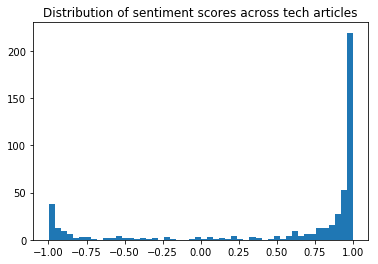

In [36]:
plt.hist(art_df['polarity'], bins=50);
plt.title('Distribution of sentiment scores across tech articles')

# WordCloud

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

v = TfidfVectorizer(stop_words='english', strip_accents= 'ascii', min_df=0.005)
a = v.fit_transform(art_df[art_df['body'].apply(lambda x: 'hamze' not in x)]['body'])

df2 = pd.DataFrame(a.toarray(), columns=v.get_feature_names())
df2.columns = [i[0].upper() + i[1:] for i in df2.columns]

wCloud = df2.sum().sort_values(ascending=False).head(200)

wCloud = wCloud/wCloud.iloc[0]*100
wCloud = wCloud.apply(lambda x: int(x))

#dump words to a js file to build a D3 wordcloud (DONT STEM)

with open('wordcloud/static/article_dump.js', 'w') as f:
    f.write('article_dump = [')
    for i in range(wCloud.shape[0]):
        f.write('{text: \'' + wCloud.index[i] + '\', size: ' + str(wCloud.iloc[i]) + '},\n')
    f.write('];')

# TFIDF, LSA Vectorization

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

dims = 250

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', tokenizer = word_tokenize, \
                        min_df=0.005, strip_accents= 'ascii', ngram_range=(1,3))),
                ('lsa', TruncatedSVD(dims, algorithm = 'arpack')),
                ('normalizer', Normalizer())])

#pipe.fit_transform(art_df['body'])

df2 = pd.DataFrame(pipe.fit_transform(art_df['body']))

pipe.steps[1][1].explained_variance_ratio_.sum()

0.76755476288236868

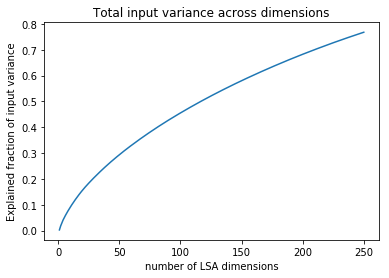

In [82]:
dims2 = range(1,dims+1)
plt.plot(dims2, np.cumsum(pipe.steps[1][1].explained_variance_ratio_))
plt.title('Total input variance across dimensions')
plt.xlabel('number of LSA dimensions')
plt.ylabel('Explained fraction of input variance')

# LSA Topic modeling

In [83]:
def print_topic_top_words(pipe, n_topics=15, n_words=6):
    cv = pipe.steps[0][1]
    model = pipe.steps[1][1]
    feature_names = cv.get_feature_names()
    
    for topic_num in range(n_topics):
        topic_mat = model.components_[topic_num]
        
        print('Topic {}:'.format(topic_num + 1).center(80))
        
        topic_values = sorted(zip(topic_mat, feature_names), 
                              reverse=True)[:n_words]
        print(' '.join([y for x,y in topic_values]))
        print('-'*80)
        
print_topic_top_words(pipe)

                                    Topic 1:                                    
compani app googl like use new
--------------------------------------------------------------------------------
                                    Topic 2:                                    
stormer daili stormer daili site domain hate
--------------------------------------------------------------------------------
                                    Topic 3:                                    
uber benchmark kalanick board compani investor
--------------------------------------------------------------------------------
                                    Topic 4:                                    
netflix disney stream tv content rhime
--------------------------------------------------------------------------------
                                    Topic 5:                                    
uber app googl benchmark kalanick netflix
-------------------------------------------------------------------

# K-means

In [84]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [85]:
n_clus=20
km = KMeans(n_clusters=n_clus)
km.fit(df2)
art_df['labels'] = km.labels_
art_df.groupby('labels')['body'].count()

labels
0     28
1     17
2     15
3     39
4     16
5      9
6     26
7     16
8     29
9      7
10    14
11    22
12    30
13    19
14    23
15    39
16    16
17    30
18    86
19    13
Name: body, dtype: int64

In [ ]:
art_df[art_df['labels']==19].title

In [86]:
#extract keywords from clusters

def get_keywords(cluster):
    tf = TfidfVectorizer(stop_words='english', tokenizer = word_tokenize, \
                        min_df=0.005, strip_accents= 'ascii', ngram_range=(1,1))
    X = tf.fit_transform(cluster).toarray()
    return ' '.join(pd.DataFrame(X, columns=tf.get_feature_names()).mean().sort_values(ascending=False).index[:3])

keywords = art_df.groupby('labels')['body'].agg(get_keywords)

In [87]:
results = art_df.groupby('labels').agg({'polarity': ['median'], 'title':'first'})
results['keywords'] = keywords
results

,polarity,title,keywords
,median,first,
labels,,,
0,0.97095,Netflix in talks to retain Marvel and Star War...,netflix disney stream
1,-0.96720,Google drops domain hosting for infamous neo-N...,stormer daili site
2,0.96980,"NGOs and nonprofits, apply to exhibit at TechC...",disrupt startup ticket
3,0.96760,Machine learning can tell if you’re wearing sw...,compani use work
4,0.93445,Mighty fills an iPod shuffle-sized hole for Sp...,devic alexa phone
5,0.97580,Military tech could be Amazon’s secret to chea...,target amazon day
6,0.97565,The Minifree Libreboot T400 is free as in freedom,batteri camera tesla
7,0.97955,Why HPE is sending a supercomputer to the ISS ...,space comput launch


# tSNE; Further dimensionality reduction

In [88]:
#run tsne so we can get a 2D visualization of clusters
from sklearn.manifold import TSNE

tsne = TSNE()

df3 = pd.DataFrame(tsne.fit_transform(df2))

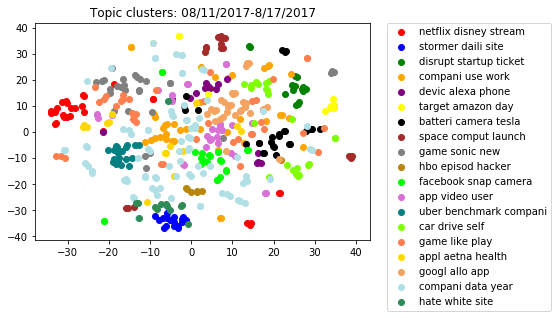

In [89]:
df3['labels'] = art_df['labels'].values

colors = ['red','blue', 'green', 'orange', 'purple', \
          'yellow', 'black', 'brown', 'gray', 'darkgoldenrod',\
          'fuchsia', 'lime', 'orchid','teal', 'chartreuse', \
          'coral', 'gold', 'sandybrown', 'powderblue', 'seagreen']


for i in range(n_clus):
    if 'tito' not in keywords.values[i]:
        plt.scatter(df3[df3['labels']==i].iloc[:,0].values, df3[df3['labels']==i].iloc[:,1].values, c= colors[i % len(colors)], label=keywords.values[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Topic clusters: 08/11/2017-8/17/2017')

In [91]:
art_df.groupby('date').count().sum()

author      494
body        494
site        494
tags        494
title       494
polarity    494
labels      494
dtype: int64

# Getting the elbow curve

In [95]:
SSEs = []
Sil_coefs = []
Inertia = []
k_range = range(2,30)

for k in k_range:
    print('Cluster numbers: ' + str(k))
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(df2)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(df2, labels, metric='euclidean'))
    # SSEs.append(get_SSE(X_digits, labels)) # The SSE is just inertia, we
    SSEs.append(km.inertia_)            # could have just said km.inertia_

Cluster numbers: 2
Cluster numbers: 3
Cluster numbers: 4
Cluster numbers: 5
Cluster numbers: 6
Cluster numbers: 7
Cluster numbers: 8
Cluster numbers: 9
Cluster numbers: 10
Cluster numbers: 11
Cluster numbers: 12
Cluster numbers: 13
Cluster numbers: 14
Cluster numbers: 15
Cluster numbers: 16
Cluster numbers: 17
Cluster numbers: 18
Cluster numbers: 19
Cluster numbers: 20
Cluster numbers: 21
Cluster numbers: 22
Cluster numbers: 23
Cluster numbers: 24
Cluster numbers: 25
Cluster numbers: 26
Cluster numbers: 27
Cluster numbers: 28
Cluster numbers: 29


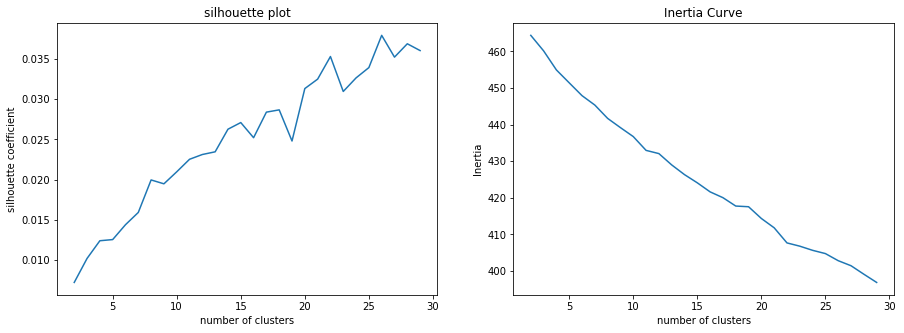

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = k_range
# the silhouete coefficient is (b - a) / max(a, b), where b(i) is the average distance between a point i and every other point from the closest cluster; 
# and a(i) is the average distance between a point i and every other point within its own cluster.  It has a value from -1,1. 1 means it belongs to the cluster.
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_title('silhouette plot')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia');
ax2.set_title('Inertia Curve')

# Other Clustering

In [ ]:
from sklearn.cluster import DBSCAN,AgglomerativeClustering, SpectralClustering
from sklearn.metrics.pairwise import cosine_distances

#metric = 'euclidean'
metric = 'cosine'

clus = DBSCAN(eps=0.4, min_samples=3, metric=metric, algorithm='brute')
#clus = SpectralClustering(n_clusters=50, affinity='cosine', n_init=15, n_neighbors=5)


clus.fit(df2)

art_df['labels'] = clus.labels_

art_df.groupby('labels')['body'].count()

In [ ]:
#What articles seem to be related?
art_df[art_df['labels'] == 12]['title'].values

# LDA Topic modeling

In [18]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

pipe2 = [
    ('tfidf', TfidfVectorizer(stop_words='english', tokenizer = word_tokenize, \
                              min_df=0.001, strip_accents= 'ascii', ngram_range=(1,3))),
    ('lda', LDA(n_topics=10, learning_method='batch'))]

pipe2 = Pipeline(pipe2)

pipe2.fit_transform(art_df['body'])

def topics(pipe, n_words=5):
    features = pipe.steps[0][1].get_feature_names()
    for i, topic in enumerate(pipe.steps[1][1].components_):
        print('Topic ID:', i+1)
        print(' '.join([features[i] for i in topic.argsort()[::-1][:n_words]]))

topics(pipe2, 6)

Topic ID: 1
compani model music like servic new
Topic ID: 2
compani app game year use user
Topic ID: 3
compani appl new servic softbank like
Topic ID: 4
compani new like use car musk
Topic ID: 5
compani year new appl game servic
Topic ID: 6
compani googl facebook million year user
Topic ID: 7
tito tito hamz hamz suit san francisco street suit san tito hamz john
Topic ID: 8
compani app fcc googl servic use
Topic ID: 9
compani use like fitbit appl devic
Topic ID: 10
compani use data app appl like
